In [2]:
from mpi4py import MPI
from manapy.ast import Variable
from manapy.base.base import Struct
from manapy.ddm import Domain
from manapy.partitions import MeshPartition
from manapy.solvers.advec.tools_utils import initialisation_gaussian_2d
import numpy as np
import time
from numba import cuda

import matplotlib.pyplot as plt

from timeit import default_timer as timer

###############
# test_time
###############

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")

###############
# init
###############
def init(dim, mesh_path):
  running_conf = Struct(backend="numba", signature=True, cache=True, precision="double")
  MeshPartition(mesh_path, dim=dim, conf=running_conf, periodic=[0,0,0])

  running_conf = Struct(backend="numba", signature=True, cache =True, precision="double")
  domain = Domain(dim=dim, conf=running_conf)
  ne = Variable(domain=domain)
  u  = Variable(domain=domain)
  v  = Variable(domain=domain)
  w  = Variable(domain=domain)
  
  P = Variable(domain=domain)
  Pinit = 2.0
  cells = domain.cells
  initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, cells.center, Pinit)

  u.face[:] = 2.
  v.face[:] = 0.
  w.face[:] = 0.
  
  u.interpolate_facetocell()
  v.interpolate_facetocell()
  w.interpolate_facetocell()
  return (domain, ne, u, v, w, P)

In [3]:
dim = 2
mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre_hybrid.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square_larger.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square_larger.msh"
domain, ne, u, v, w, P = init(dim=dim, mesh_path=mesh_file)

Reading gmsh file ...
Saving partition files ...
Number of Cells: 105826
Number of Vertices: 53314
Local domain contruction ...


In [4]:
from manapy.solvers.ls import PETScKrylovSolver

# put this code to PETScKrylovSolver init function so bypass the import of petsc4py
"""
    # try_imports(['import petsc4py',],
    #             'cannot import petsc4py solver!')
    
    # from petsc4py import PETSc as petsc
    
    #self.petsc = petsc
    self.ksp   = None
    
    self.converged_reasons = {}                                                                                                                                                                             
    # for key, val in six.iteritems(petsc.KSP.ConvergedReason.__dict__):                                                                                                                                 
    #     if isinstance(val, int):                                                                                                                                                                       
    #         self.converged_reasons[val] = key    
"""

conf = Struct(reuse_mtx=True, scheme='diamond', verbose=False, precision="single")
L = PETScKrylovSolver(domain=domain, var=P, conf=conf)

SetUp the Linear system ...


In [5]:
from numba import cuda

def create_var(v):
  return (v, cuda.to_device(v))


L.update_ghost_values()
L.var.BCdirichlet = L.domain.nodes.oldname

host_P_c, d_P_c = create_var(L.var.cell)
host_P_ghost, d_P_ghost = create_var(L.var.ghost)
host_P_halo, d_P_halo = create_var(L.var.halo)
host_P_node, d_P_node = create_var(L.var.node)
host_cellidf, d_cellidf = create_var(L.domain.faces.cellid)
host_nodeidf, d_nodeidf = create_var(L.domain.faces.nodeid)
host_centergf, d_centergf = create_var(L.domain.faces.ghostcenter)
host_halofid, d_halofid = create_var(L.domain.faces.halofid)
host_centerc, d_centerc = create_var(L.domain.cells.center)
host_centerh, d_centerh = create_var(L.domain.halos.centvol)
host_oldname, d_oldname = create_var(L.domain.nodes.oldname)
host_airDiamond, d_airDiamond = create_var(L.domain.faces.airDiamond)
host_f_1, d_f_1 = create_var(L.domain.faces.f_1)
host_f_2, d_f_2 = create_var(L.domain.faces.f_2)
host_f_3, d_f_3 = create_var(L.domain.faces.f_3)
host_f_4, d_f_4 = create_var(L.domain.faces.f_4)
host_normalf, d_normalf = create_var(L.domain.faces.normal)
host_shift, d_shift = create_var(L.domain.cells.shift)
host_Pbordnode, d_Pbordnode = create_var(L.domain.Pbordnode)
host_Pbordface, d_Pbordface = create_var(L.domain.Pbordface)
host_Px_face, d_Px_face = create_var(L.var.gradfacex)
host_Py_face, d_Py_face = create_var(L.var.gradfacey)
host_Pz_face, d_Pz_face = create_var(L.var.gradfacez)
host_BCdirichlet, d_BCdirichlet = create_var(L.var.BCdirichlet)
host_innerfaces, d_innerfaces = create_var(L.domain.innerfaces)
host_halofaces, d_halofaces = create_var(L.domain.halofaces)
host_neumannfaces, d_neumannfaces = create_var(L.var.neumannfaces)
host_dirichletfaces, d_dirichletfaces = create_var(L.var.dirichletfaces)
host_periodicfaces, d_periodicfaces = create_var(L.domain.periodicboundaryfaces)





In [7]:
print(host_Px_face.dtype, d_Px_face.dtype)
print(host_Py_face.dtype, d_Py_face.dtype)

float64 float64
float64 float64


In [6]:
#The original function from functions2d.py

from numpy import  int32, float32, uint32
import numpy as np

def compute_P_gradient_2d_diamond(P_c:'float[:]', P_ghost:'float[:]', P_halo:'float[:]', P_node:'float[:]', cellidf:'int32[:,:]', 
                                  nodeidf:'int32[:,:]', centergf:'float[:,:]',  halofid:'int32[:]', centerc:'float[:,:]', 
                                  centerh:'float[:,:]', oldname:'uint32[:]', airDiamond:'float[:]', f_1:'float[:,:]', f_2:'float[:,:]',
                                  f_3:'float[:,:]', f_4:'float[:,:]', normalf:'float[:,:]', shift:'float[:,:]', Pbordnode:'float[:]', 
                                  Pbordface:'float[:]', 
                                  Px_face:'float[:]', Py_face:'float[:]', Pz_face:'float[:]', BCdirichlet:'uint32[:]', innerfaces:'uint32[:]',
                                  halofaces:'uint32[:]', neumannfaces:'uint32[:]', dirichletfaces:'uint32[:]', periodicfaces:'uint32[:]'):
    
    def search_element(a:'int32[:]', target_value:'int32'):
        find = 0
        for val in a:
            if val == target_value:
                find = 1
                break
        return find
    
    for i in innerfaces:
        
        c_left = cellidf[i][0]
        c_right = cellidf[i][1]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
        
        vi1 = P_node[i_1]
        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            vi1 = Pbordnode[i_1]
        vi2 = P_node[i_2]
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            vi2 = Pbordnode[i_2]

        vv1 = P_c[c_left]
        vv2 = P_c[c_right]
        
        Px_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        Py_face[i] =  1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])
     
    for i in periodicfaces:
        
        c_left = cellidf[i][0]
        c_right = cellidf[i][1]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
        
        vi1 = P_node[i_1]
        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            vi1 = Pbordnode[i_1]
        vi2 = P_node[i_2]
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            vi2 = Pbordnode[i_2]

        vv1 = P_c[c_left]
        vv2 = P_c[c_right]
        
        Px_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        Py_face[i] =  1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])
    
    for i in neumannfaces:
        
        c_left = cellidf[i][0]
        c_right = i
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
            
        vi1 = P_node[i_1]
        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            vi1 = Pbordnode[i_1]
        vi2 = P_node[i_2]
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            vi2 = Pbordnode[i_2]

        vv1 = P_c[c_left]
        vv2 = P_ghost[c_right]
            
        Px_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        Py_face[i] =  1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])
            
    for i in halofaces:

        c_left = cellidf[i][0]
        c_right = halofid[i]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
        
        vi1 = P_node[i_1]
        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            vi1 = Pbordnode[i_1]
        vi2 = P_node[i_2]
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            vi2 = Pbordnode[i_2]
        
        vv1 = P_c[c_left]
        vv2 = P_halo[c_right]
        
        Px_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        Py_face[i] =  1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])
    
    for i in dirichletfaces:
        
        c_left = cellidf[i][0]
        c_right = i
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
        
        vi1 = Pbordnode[i_1]
        vi2 = Pbordnode[i_2]
        vv1 = P_c[c_left]
        
        VK = Pbordface[i]
        vv2 = 2. * VK - vv1

        Px_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        Py_face[i] =  1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])



In [8]:
#? using numba jit -> backend.py
#! Using parallel=True yields poor results.
import numba

numba_compute_P_gradient_2d_diamond = numba.jit(compute_P_gradient_2d_diamond, nopython=True, fastmath=True, parallel=False, cache=True)
def cpu_compute_P_gradient_2d_diamond():
  return numba_compute_P_gradient_2d_diamond(
    host_P_c,
    host_P_ghost,
    host_P_halo,
    host_P_node,
    host_cellidf,
    host_nodeidf,
    host_centergf,
    host_halofid,
    host_centerc,
    host_centerh,
    host_oldname,
    host_airDiamond,
    host_f_1,
    host_f_2,
    host_f_3,
    host_f_4,
    host_normalf,
    host_shift,
    host_Pbordnode,
    host_Pbordface,
    host_Px_face,
    host_Py_face,
    host_Pz_face,
    host_BCdirichlet,
    host_innerfaces,
    host_halofaces,
    host_neumannfaces,
    host_dirichletfaces,
    host_periodicfaces,
  )


In [19]:
#time taken by cpu_compute_P_gradient_2d_diamond

initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, domain.cells.center, 2.0)

cpu_compute_P_gradient_2d_diamond()
test_time(70, cpu_compute_P_gradient_2d_diamond)

200.77169 ms


In [16]:
@cuda.jit(device=True)
def search_element(a:'int32[:]', target_value:'int32'):
    for i in range(a.shape[0]):
        if a[i] == target_value:
            return 1
    return 0

@cuda.jit()
def kernel_compute_P_gradient_2d_diamond(P_c:'float[:]', P_ghost:'float[:]', P_halo:'float[:]', P_node:'float[:]', cellidf:'int32[:,:]', 
                                  nodeidf:'int32[:,:]', centergf:'float[:,:]',  halofid:'int32[:]', centerc:'float[:,:]', 
                                  centerh:'float[:,:]', oldname:'uint32[:]', airDiamond:'float[:]', f_1:'float[:,:]', f_2:'float[:,:]',
                                  f_3:'float[:,:]', f_4:'float[:,:]', normalf:'float[:,:]', shift:'float[:,:]', Pbordnode:'float[:]', 
                                  Pbordface:'float[:]', 
                                  Px_face:'float[:]', Py_face:'float[:]', Pz_face:'float[:]', BCdirichlet:'uint32[:]', innerfaces:'uint32[:]',
                                  halofaces:'uint32[:]', neumannfaces:'uint32[:]', dirichletfaces:'uint32[:]', periodicfaces:'uint32[:]'):

    idx = cuda.grid(1)

    if idx < innerfaces.shape[0]:
        i = innerfaces[idx]

        c_left = cellidf[i][0]
        c_right = cellidf[i][1]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
        
        vi1 = P_node[i_1]
        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            vi1 = Pbordnode[i_1]
        vi2 = P_node[i_2]
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            vi2 = Pbordnode[i_2]

        vv1 = P_c[c_left]
        vv2 = P_c[c_right]
        
        Px_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        Py_face[i] =  1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])
     
    if idx < periodicfaces.shape[0]:
        i = periodicfaces[idx]
        
        c_left = cellidf[i][0]
        c_right = cellidf[i][1]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
        
        vi1 = P_node[i_1]
        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            vi1 = Pbordnode[i_1]
        vi2 = P_node[i_2]
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            vi2 = Pbordnode[i_2]

        vv1 = P_c[c_left]
        vv2 = P_c[c_right]
        
        Px_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        Py_face[i] =  1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])
    
    if idx < neumannfaces.shape[0]:
        i = neumannfaces[idx]
        
        c_left = cellidf[i][0]
        c_right = i
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
            
        vi1 = P_node[i_1]
        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            vi1 = Pbordnode[i_1]
        vi2 = P_node[i_2]
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            vi2 = Pbordnode[i_2]

        vv1 = P_c[c_left]
        vv2 = P_ghost[c_right]
            
        Px_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        Py_face[i] =  1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])
            
    if idx < halofaces.shape[0]:
        i = halofaces[idx]

        c_left = cellidf[i][0]
        c_right = halofid[i]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
        
        vi1 = P_node[i_1]
        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            vi1 = Pbordnode[i_1]
        vi2 = P_node[i_2]
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            vi2 = Pbordnode[i_2]
        
        vv1 = P_c[c_left]
        vv2 = P_halo[c_right]
        
        Px_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        Py_face[i] =  1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])
    
    if idx < dirichletfaces.shape[0]:
        i = dirichletfaces[idx]
        
        c_left = cellidf[i][0]
        c_right = i
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
        
        vi1 = Pbordnode[i_1]
        vi2 = Pbordnode[i_2]
        vv1 = P_c[c_left]
        
        VK = Pbordface[i]
        vv2 = 2. * VK - vv1

        Px_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        Py_face[i] =  1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])

        




In [17]:
import numba


nb_element = max(
  d_innerfaces.shape[0],
  d_periodicfaces.shape[0],
  d_neumannfaces.shape[0],
  d_halofaces.shape[0],
  d_dirichletfaces.shape[0])

nb_threads = 32
nb_blocks = nb_element // nb_threads + 1
print(nb_blocks)


def cuda_compute_P_gradient_2d_diamond():
  kernel_compute_P_gradient_2d_diamond[nb_blocks, nb_threads](
    d_P_c,
    d_P_ghost,
    d_P_halo,
    d_P_node,
    d_cellidf,
    d_nodeidf,
    d_centergf,
    d_halofid,
    d_centerc,
    d_centerh,
    d_oldname,
    d_airDiamond,
    d_f_1,
    d_f_2,
    d_f_3,
    d_f_4,
    d_normalf,
    d_shift,
    d_Pbordnode,
    d_Pbordface,
    d_Px_face,
    d_Py_face,
    d_Pz_face,
    d_BCdirichlet,
    d_innerfaces,
    d_halofaces,
    d_neumannfaces,
    d_dirichletfaces,
    d_periodicfaces,
  )
  cuda.synchronize()

cuda_compute_P_gradient_2d_diamond()
test_time(70, cuda_compute_P_gradient_2d_diamond)

4949
15.97620 ms


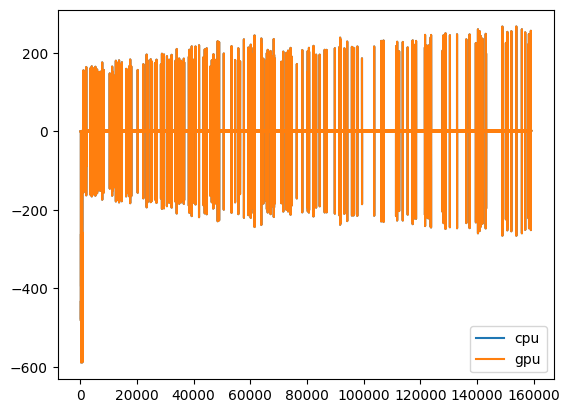

In [18]:
def verify(a, b, decimal, plot):
  b = b.copy_to_host()
  if plot == True:
    plt.plot(a, label="cpu")
    plt.plot(b, label="gpu")
    plt.legend()
    plt.show()
  np.testing.assert_almost_equal(a, b, decimal=decimal, )


verify(host_Px_face, d_Px_face, decimal=2, plot=True)